In [ ]:
# !pip install timm
import timm 
timm.list_models(pretrained=True)

In [209]:

import torch

device = 'cuda:1'

model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)

In [208]:
import pandas as pd
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import os
import cv2

class CustomDataset(Dataset):
    def __init__(self,  img_dir, files,transform=None):
        self.img_labels = files
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = cv2.imread(img_path)
        if 'fake' in img_path:
            label=torch.LongTensor([0])
        else:
            label=torch.LongTensor([1])
        if self.transform:
            image = self.transform(image)
        return image.to(device), label.to(device)


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])
hqf2f = 'High Quality/f2f_data'
hqnt = 'High Quality/nt_data'
lqf2f = 'Low Quality/f2f_data'
lqnt = 'Low Quality/nt_data'

file_directories = [hqf2f, hqnt, lqf2f, lqnt]

test_dir = file_directories[0]+'/test'
train_dir = file_directories[0]+'/train'
valid_dir = file_directories[0] +'/val'
testimages = os.listdir(test_dir)
trainimages = os.listdir(train_dir)
validimages = os.listdir(valid_dir)

test_dataset = CustomDataset(test_dir, testimages, transform)
train_dataset = CustomDataset(train_dir, trainimages, transform)
valid_dataset = CustomDataset(valid_dir, validimages, transform)
batchsize = 32
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=True)



In [210]:
from torch.nn import CrossEntropyLoss
from torch import optim
loss_func = CrossEntropyLoss()
epoch = 100
optimizer = optim.AdamW(model.parameters())
train_losses =[]
train_accuracy =[]
valid_losses =[]
valid_accuracy =[]
for i in range(epoch):
    total = 0
    train_correct = 0
    epoch_loss =0
    model.train()
    for batch, (image ,label) in enumerate(train_dataloader):
        prediction = model(image)
        label = label.squeeze(dim=1)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(prediction, 1)
        total += label.size(0)
        train_correct += (predicted.cpu() == label.cpu()).sum().item()
        epoch_loss += loss  
    
    epoch_loss /= len(train_dataloader)
    train_losses.append(epoch_loss.item())
    train_accuracy.append(train_correct / total)

    if epoch % 2 == 0:
        print(epoch)
        model.eval()
        with torch.no_grad():
            valid_total =0
            valid_loss =0
            valid_correct = 0
            for batch , (image, label) in enumerate(valid_dataloader):
                prediction = model(image)
                label = label.squeeze(dim=1)
                valid_loss += loss_func(prediction, label)
                valid_total += label.size(0)
                _, predicted = torch.max(prediction,1)
                valid_correct += (predicted.cpu() == label.cpu()).sum().item()

            valid_loss /= len(valid_dataloader)
            valid_losses.append(valid_loss.item()) 
            valid_accuracy.append(valid_correct / valid_total)
    

[2.0174930095672607] [0.7591666666666667] [0.8375113010406494] [0.8930348258706468]
[2.0174930095672607, 0.37426167726516724] [0.7591666666666667, 0.9175] [0.8375113010406494, 0.41475987434387207] [0.8930348258706468, 0.900497512437811]
[2.0174930095672607, 0.37426167726516724, 0.12684381008148193] [0.7591666666666667, 0.9175, 0.96] [0.8375113010406494, 0.41475987434387207, 0.22599683701992035] [0.8930348258706468, 0.900497512437811, 0.9552238805970149]
[2.0174930095672607, 0.37426167726516724, 0.12684381008148193, 0.034428440034389496] [0.7591666666666667, 0.9175, 0.96, 0.9866666666666667] [0.8375113010406494, 0.41475987434387207, 0.22599683701992035, 0.19998426735401154] [0.8930348258706468, 0.900497512437811, 0.9552238805970149, 0.945273631840796]
[2.0174930095672607, 0.37426167726516724, 0.12684381008148193, 0.034428440034389496, 0.012194947339594364] [0.7591666666666667, 0.9175, 0.96, 0.9866666666666667, 0.9941666666666666] [0.8375113010406494, 0.41475987434387207, 0.2259968370199

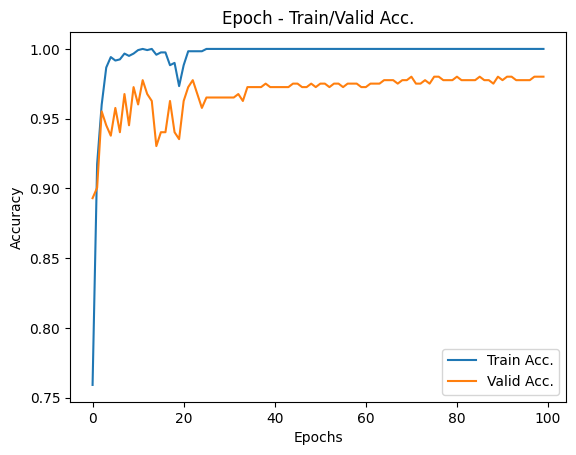

In [212]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(np.arange(0, 100, 1, dtype=np.int32))

plt.plot(epochs, train_accuracy, label='Train Acc.')
plt.plot(epochs, valid_accuracy, label='Valid Acc.')

plt.title('Epoch - Train/Valid Acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('efficientnet_b0_high_quality_f2f_accuracy')
plt.show()

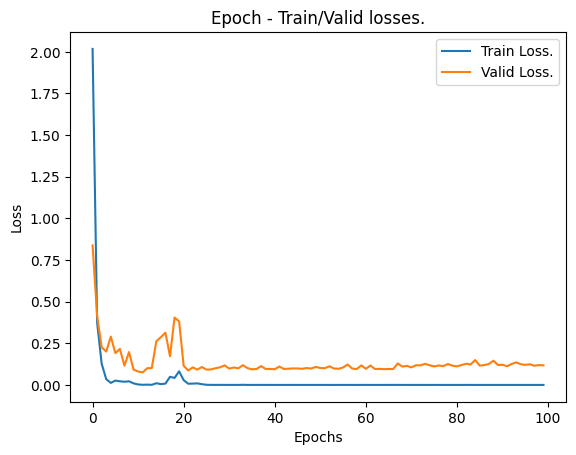

In [214]:

plt.plot(epochs, train_losses, label='Train Loss.')
plt.plot(epochs, valid_losses, label='Valid Loss.')

plt.title('Epoch - Train/Valid losses.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('efficientnet_b0_high_quality_f2f_Loss')
plt.show()

In [220]:
from sklearn.metrics import precision_score, recall_score, f1_score


test_dataloader = DataLoader(test_dataset, batch_size=batchsize)
with torch.no_grad():
    test_total =0
    test_loss =0
    test_correct = 0
    test_predicts =[]
    test_labels=[]
    for batch , (image, label) in enumerate(test_dataloader):
        prediction = model(image)
        label = label.squeeze(dim=1)
        test_loss += loss_func(prediction, label)
        test_total += label.size(0)
        _, predicted = torch.max(prediction,1)
        test_correct += (predicted.cpu() == label.cpu()).sum().item()
        test_predicts.append(predicted)
        test_labels.append(label)

    test_predicts = torch.cat(test_predicts,dim=0).detach().cpu().numpy()
    test_labels = torch.cat(test_labels, dim=0).detach().cpu().numpy()
    precision = precision_score(test_labels, test_predicts)
    recall = recall_score(test_labels, test_predicts)
    f1 = f1_score(test_labels, test_predicts)
    test_loss /= len(test_dataloader)
    test_accuracy=test_correct / test_total

    print(test_accuracy, f1, precision,recall)

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1'), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1'), tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1'), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1'), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1'), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1'), tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1], device='cuda:1'), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
  